** Some imports **

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
%matplotlib inline

** Load Data ** 

In [2]:
names = ['ind', 'ax', 'ay', 'az', 'label']
acc_names = ['ax', 'ay', 'az']
label2str = {1:'Working at Computer', 2:'Standing Up, Walking and Going up-down stairs', 
             3:'Standing', 4:'Walking',5:'Going Up\Down Stairs', 6:'Walking and Talking with Someone', 
             7:'Talking while Standing'}
df = pd.read_csv("Dataset/1.csv", sep=',', names=names)
del df['ind']
df = df[df.label != 0]
df['label_str'] = df.label.apply(lambda x:label2str[x])

** Add signals ** 

In [3]:
# Magnitude
df['mag'] = np.sqrt(np.square(df[acc_names]).sum(axis=1)) 
# Median filter - 3rd ordre
def med_fil(df, names):
    df_r = pd.DataFrame()
    df = df[names]
    for column in df.columns:
        name = column+'_mf'
        df_r[name] = signal.medfilt(df[column].values)
    return df_r
df_med = med_fil(df, acc_names)
# Diffrential
def diffrential(df, names):
    df = df[names]
    df_r = df.diff(periods=1, axis=0).fillna(method='backfill')
    df_r.columns = [names[0]+'_d', names[1]+'_d', names[2]+'_d']
    return df_r
df_diff = diffrential(df, acc_names)
# Low pass filter
def lowpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='low')
    for column in df.columns : 
        name = column+'_lp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_lp = lowpass(df, acc_names)  
# High pass filter 
def highpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='high')
    for column in df.columns : 
        name = column+'_hp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_hp = highpass(df, acc_names)

# Total
df = pd.concat([df, df_med, df_diff, df_lp, df_hp], axis=1)
df.head()

,ax,ay,az,label,label_str,mag,ax_mf,ay_mf,az_mf,ax_d,ay_d,az_d,ax_lp,ay_lp,az_lp,ax_hp,ay_hp,az_hp
0,1502,2215,2153,1,Working at Computer,3434.768988,1502,2072,2047,165,-143,-106,0.294570,0.434402,0.422243,1330.950456,1962.753168,1907.813802
1,1667,2072,2047,1,Working at Computer,3355.932359,1611,2072,2047,165,-143,-106,2.023204,2.907854,2.832932,1155.714581,1362.002403,1353.118154
2,1611,1957,1906,1,Working at Computer,3171.435952,1611,1957,1906,-56,-115,-141,7.011663,9.821684,9.584772,789.314495,875.625099,847.401747
3,1601,1939,1831,1,Working at Computer,3110.543843,1611,1957,1879,-10,-18,-75,16.960462,23.217970,22.667546,517.382527,551.056967,481.033069
4,1643,1965,1879,1,Working at Computer,3176.683018,1604,1959,1879,42,26,48,33.066246,44.414894,43.325413,330.972495,313.877533,283.050573


In [ ]:
names = ['ax','ay','az','mag','ax_mf','ay_mf','az_mf','ax_lp','ay_lp','az_lp', 'ax_hp','ay_hp','az_hp']


def extract_variables(df):
    def rms(df, names):
        # TODO
        pass
    def minmax(df, names=names):
        res = []
        for column in df.columns:   
            if column not in  :
                i_min = df[column].argmin()
                i_max = df[column].argmax()
                i1 = min(i_min, i_max)
                i2 = max(i_min, i_max)
                m = df[column].values[i1:i2].mean()
                res.append(m)
        return res
        
    m = df.mean(axis=0).values
    ma = df.mad(axis=0).values
    std = df.std(axis=0).values
    minimum = df.min(axis=0).values
    maximum = df.max(axis=0).values
    skew = df.skew(axis=0).values
    kurt = df.kurtosis(axis=0).values
#     minmax = minmax(df, names) 
#     rms = rms(df, names) # TODO
    inteQ = (df.quantile(q=0.75) - df.quantile(q=0.25)).values
    r = np.hstack([m, ma, std, minimum, maximum, skew, kurt, inteQ])    
    return r

### Windowing

In [ ]:
def windowing(signal,size,step):
    d = len(signal) #length of the signal
    nk = int(np.floor((d-size+1)/step))+1 #le nombre de fenetres
    wk = np.zeros((nk,size)) #windows
    for j in range(nk):
        wk[j,:] = signal[j*step:j*step+size]
    return wk

In [ ]:
def window_labels(labels,size,step):
    d = len(labels) #length of the signal
    nk = int(np.floor((d-size+1)/step))+1 #le nombre de fenetres
    labelwk = np.zeros((nk)) #window labels
    for j in range(nk):
        labelwk[j] = np.max(np.argmax(np.bincount(labels[j*step:j*step+size])))
    return labelwk

In [ ]:
def extract_windows(df,size,step):
    
    """
    extract windows with the specified size and step from the dataframe df
    
    Returns:
    L : List of dataframes. Each dataframe contains a window extracted from each signal in df.
    labels: labels of windows
    """
    
    L = []
    n = df.shape[0]
    L_windows = dict()
    n_windows = int(np.floor((n-size+1)/step))+1
    for column in df.columns:
        if column not in ['label','label_str']:
            L_windows[column] = windowing(df[column],size,step)
    for i in range(n_windows):
        ddf = pd.DataFrame()
        for column in df.columns:
            if column not in ['label','label_str']:
                ddf[column] = L_windows[column][i,:]
        L.append(ddf)
    labels = window_labels(df['label'],size,step)
    
    return L,labels

In [ ]:
Nbr_samples = 52
percentage = 0.5 # Between 0 & 1
df_X, df_Y = extract_windows(df,Nbr_samples,percentage*Nbr_samples)

** Extract Matrix of Features ** 

In [ ]:
X = extract_variables(df_X[0])
for i in range(1,len(df_X)):
    vec = extract_variables(df_X[i])
    X = np.vstack([X,vec])
    
y = np.array(df_Y) 



** Machine Learning **

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
X = scale(X)
knn.fit(X,y)
print('training score: '+str(knn.score(X,y)))

In [ ]:
confusion_matrix(y, knn.predict(X))

In [ ]:
lrcv = LogisticRegressionCV(Cs=10, cv=None, penalty='l1', solver='liblinear', n_jobs=8, multi_class='ovr')
lrcv.fit(X,y)
print('training score: '+str(lrcv.score(X,y)))

In [ ]:
param_grid = {'n_neighbors':[3,5,10,15,20,25]}
knncv = GridSearchCV(estimator=knn, param_grid=parm_grid)
knncv.fit(X,y)

In [ ]:
print(knncv.cv_results_)
print(knncv.get_params())

In [ ]:
from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier(n_neighbors=5)
print(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))

In [ ]:
a = df.groupby('label')
S = a.get_group(1).cov()
del S['label']
S = S.drop(['label'])
for i in range(2,len(a)):
    S1 = a.get_group(i).cov()
    S1 = S1.drop(['label'])
    del S1['label']
    S = S + S1
S

# KDA

In [59]:
df_KDA = df.copy()
del df_KDA['label_str']

In [72]:
# Within-class scatter matrix
a = df_KDA.groupby('label')
Sw = a.get_group(1).cov()
del Sw['label']
Sw = Sw.drop(['label'])
for i in range(2,len(a)):
    S1 = a.get_group(i).cov()
    S1 = S1.drop(['label'])
    del S1['label']
    Sw = Sw + S1

In [73]:
# Between-class scatter matrix
C = 7 # Number of classes
Nf = 16 # Number of features
a = df_KDA.mean(axis=0)
del a['label']
u = a.values
Sb = np.zeros((Nf,Nf))
for i in range(C):
    Ni = df_KDA.groupby('label').count().ax[i+1]
    a = df_KDA.groupby('label').get_group(i+1).mean()
    del a['label']    
    ui = a.values
    x = ui-u
    x = x[:, None]
    Sb += Ni*np.dot(x,x.T)

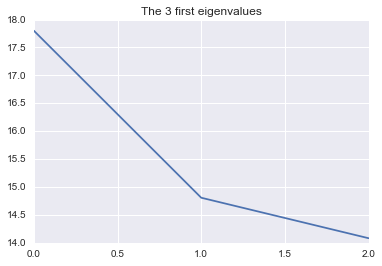

In [133]:
# Projection Matrix Theta
Proj_dim=3
I = np.linalg.inv(Sw)
lam=np.linalg.eig(I*Sb)[0][0:Proj_dim]
Theta = np.linalg.eig(I*Sb)[1][0:Proj_dim]
Y = np.dot(Theta, df_KDA.values.T).T # Projected data
plt.plot(np.log(lam))
plt.title('The '+ str(Proj_dim)+' first eigenvalues')

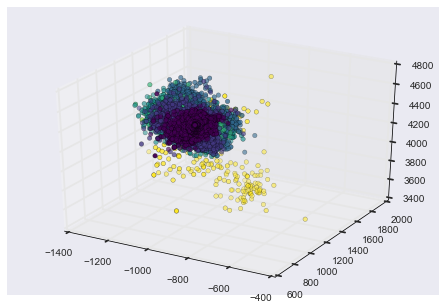

In [129]:
# Display projected data in 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Colormap

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Y[:,0],Y[:,1], Y[:,2], c=label, cmap='viridis_r')